<a href="https://colab.research.google.com/github/lamateam2023/Movie-Recommender/blob/main/Copy_of_Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Pandas
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Load Movies dataset
# imdb_data = pd.read_csv('/content/drive/MyDrive/tmdb /movies_metadata30.csv', low_memory=False)

url = 'https://raw.githubusercontent.com/lamateam2023/Movie-Recommender/main/movies_metadata30.csv'
imdb_data = pd.read_csv(url)

# Print the first three rows
imdb_data.head(3)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


First step is to clean the dataset by removing unnecessary data elements to simplify manipulation and overhead. Here we chose an easier approach by creating a second dataset containing only necessary data elements to be used throughout this project.

In [ ]:
# Create a second CLEANER dataset containing needed columns only for recommender system
metadata = imdb_data[['id','title','release_date','overview','vote_average','vote_count']]
# Display first 10 records of the clean dataset
metadata.head(10)


,id,title,release_date,overview,vote_average,vote_count
0,862,Toy Story,1995-10-30,"Led by Woody, Andy's toys live happily in his ...",7.7,5415.0
1,8844,Jumanji,1995-12-15,When siblings Judy and Peter discover an encha...,6.9,2413.0
2,15602,Grumpier Old Men,1995-12-22,A family wedding reignites the ancient feud be...,6.5,92.0
3,31357,Waiting to Exhale,1995-12-22,"Cheated on, mistreated and stepped on, the wom...",6.1,34.0
4,11862,Father of the Bride Part II,1995-02-10,Just when George Banks has recovered from his ...,5.7,173.0
5,949,Heat,1995-12-15,"Obsessive master thief, Neil McCauley leads a ...",7.7,1886.0
6,11860,Sabrina,1995-12-15,An ugly duckling having undergone a remarkable...,6.2,141.0
7,45325,Tom and Huck,1995-12-22,"A mischievous young boy, Tom Sawyer, witnesses...",5.4,45.0
8,9091,Sudden Death,1995-12-22,International action superstar Jean Claude Van...,5.5,174.0
9,710,GoldenEye,1995-11-16,James Bond must unmask the mysterious head of ...,6.6,1194.0


For the visualisation part, here are the votes of top 5 movies

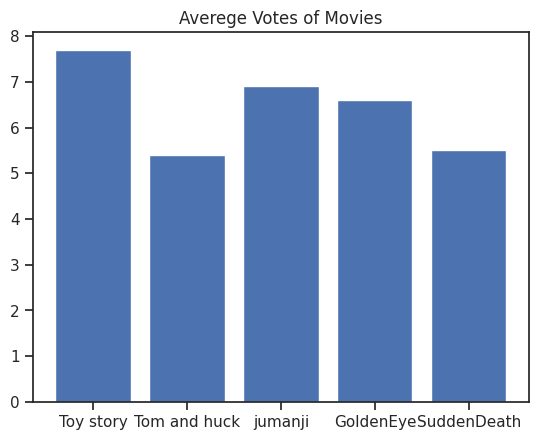

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
url = 'https://raw.githubusercontent.com/lamateam2023/Movie-Recommender/main/movies_metadata30.csv'
imdb_data = pd.read_csv(url)
imdb_data.head(10)


bar_labels = ['Toy story', 'Tom and huck', 'jumanji','GoldenEye','SuddenDeath']
means = [7.7,5.4,6.9,6.6,5.5]
plt.bar(bar_labels, means)
plt.title("Averege Votes of Movies", fontsize=12)
plt.show()

In the next few snippets we will add a new column 'score' which will have the IMDB weighted average based on the formula:

(V ÷ (V+M)) × R + (M ÷ (V+M)) × C

where the variables are:

V is the number of votes for the movie;

M is the minimum votes required to be listed in the chart;

R is the average rating of the movie;

C is the mean vote across the whole data.

In [ ]:
# First, we calculate mean of vote average column 'C'
C = metadata['vote_average'].mean()
print(C)

5.7845407567928


Next we calculate 'M' the cutoff the 90th percentile. In other words, for a movie to be featured in the charts, it must have more votes than at least 90% of the movies on the list. As calculated below, only movies with 257 or more votes will be included in the movie recommendation. The value 0.90 can be adjusted as needed to get a better result.

In [ ]:
# Calculate the minimum number of votes required to be in the chart 'M'
m = metadata['vote_count'].quantile(0.90)
print(m)


257.0


In [ ]:
# Filter out all qualified movies into a new DataFrame
qualified_movies = metadata.copy().loc[metadata['vote_count'] >= m]
qualified_movies.shape


(3007, 6)

In [ ]:
# Function that computes the weighted rating of each movie
# Based on the IMDB formula described ubove
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

# Add new column 'score' with values calculated by `weighted_rating()`
qualified_movies['score'] = qualified_movies.apply(weighted_rating, axis=1)

# Use the new column 'score' to sort movies
qualified_movies = qualified_movies.sort_values('score', ascending=False)

#Print the top 15 QUALIFIED movies
qualified_movies[['title', 'vote_count', 'vote_average', 'score']].head(20)



,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.418993
834,The Godfather,6024.0,8.5,8.388891
12481,The Dark Knight,12269.0,8.3,8.248390
2843,Fight Club,9678.0,8.3,8.234930
292,Pulp Fiction,8670.0,8.3,8.227582
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.171816
522,Schindler's List,4436.0,8.3,8.162247
23673,Whiplash,4376.0,8.3,8.160463
5481,Spirited Away,3968.0,8.3,8.146989
2211,Life Is Beautiful,3643.0,8.3,8.134238


In [ ]:
#Print plot overviews of the first 5 movies.
metadata['overview'].head()


0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

Next we use TF-IDF vectorizer class from scikit-learn library (Term Frequency - Inverse Document Frequency) which is an algorithm that uses the frequency of words to determine how relevant those words are to a given title to create a TF-IDF matrix 'tfidf_matrix'

In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object.
#Remove all english stop words such as 'the', 'an', etc
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
metadata['overview'] = metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata['overview'])

#Output the shape of tfidf_matrix, showing 30k rows as original dataset
tfidf_matrix.shape


(29999, 58560)

In the next steps, will create a similarity score matrix (30K X 30K) using TFIDF matrix created earlier to identify similarities between any two movies. As a result, each movie will have column of similarity scores against othe titles in the dataset.

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
sim_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

sim_matrix.shape


(29999, 29999)

Before creating the main recommendation function, we need to build a list of movie titles and movie Ids to easily find movie id to use when referencing original dataset 'metadata'

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()
indices[:10]



title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
Heat                           5
Sabrina                        6
Tom and Huck                   7
Sudden Death                   8
GoldenEye                      9
dtype: int64

Finally, the main function which will return 10 recommendations based on title submitted utilizing the similarity matrix.

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, sim_matrix=sim_matrix):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(sim_matrix[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]


The main function of the recommendation project. Basically enter a movie name to get best 10 recommendation movies based on similarity..

In [ ]:
#Testing main function by calling it with movie name
get_recommendations('The Dark Knight Rises')

12481                                      The Dark Knight
150                                         Batman Forever
1328                                        Batman Returns
15511                           Batman: Under the Red Hood
585                                                 Batman
21194    Batman Unmasked: The Psychology of the Dark Kn...
9230                    Batman Beyond: Return of the Joker
18035                                     Batman: Year One
19792              Batman: The Dark Knight Returns, Part 1
3095                          Batman: Mask of the Phantasm
Name: title, dtype: object